In [12]:
from Quantum_functions import hamiltonian, Heisenberg1dRingGen, make_hermitian, equilibration_analyser, get_equilibrated_dens_op, energy_trace_comparison
from QuantumLib import equilibration_analyser_p, get_equilibrated_dens_op_P, energy_trace_compare_p
from qutip import tensor, Qobj
from qutip.states import basis
from qutip.random_objects import rand_unitary_haar
import numpy as np
import ray
from matplotlib import pyplot as plt
from time import time

In [3]:
ray.init()

2020-04-04 22:49:08,184	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-04 22:49:08,186	INFO resource_spec.py:212 -- Starting Ray with 8.15 GiB memory available for workers and up to 4.09 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-04 22:49:08,533	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.97',
 'redis_address': '192.168.1.97:27327',
 'object_store_address': '/tmp/ray/session_2020-04-04_22-49-08_184251_5238/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-04_22-49-08_184251_5238/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-04_22-49-08_184251_5238'}

In [4]:
n = 8
state1 = tensor([basis(2,0)]*n)

alpha1 = Heisenberg1dRingGen(1,1,1,n)
alpha0 = lambda n,m,i,j: 0
beta1 = lambda n,i : [0,0,1][i]
beta0 = lambda n,i :0

self_interaction = hamiltonian(alpha1,beta0,n)
self_interaction = self_interaction/self_interaction.norm()
external_interaction = hamiltonian(alpha0,beta1,n)
external_interaction = external_interaction/external_interaction.norm()


perturbation: Qobj = make_hermitian(rand_unitary_haar(2**n, dims = self_interaction.dims))
perturbation = perturbation/perturbation.norm()
epsilon = 0.1

H1 = epsilon*self_interaction + external_interaction + epsilon**2*perturbation
H2 = external_interaction
H3 = external_interaction + epsilon*perturbation
H4 = self_interaction + epsilon*external_interaction + epsilon**2*perturbation

energys,states  = H1.eigenstates()
coefs = [state.overlap(state1) for state in states]

#### Testing Equilibrated Density Operator

In [5]:
d1 = get_equilibrated_dens_op(H1,state1)
d2 = get_equilibrated_dens_op_P(states,coefs,n)

assert(np.allclose(d1,d2))


#### Testing Equilibration

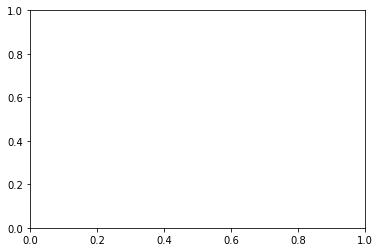

In [6]:
xs,ys = equilibration_analyser(H1,state1,1e5,100, test = True)

xs2,ys2 = equilibration_analyser_p(energys, states, state1, 1e5, 100, "Test", test = True)

In [7]:
ys = np.array(ys)
ys2 = np.array(ys2)

assert(np.allclose(ys,ys2, atol=0.0001))

#### Testing Trace Energy Compare

In [13]:
t_start =time()
es,ts = energy_trace_comparison(H1,1,1)
t_end =time()
es2,ts2 = energy_trace_compare_p(H1,1,1)
t_end2 =time()

print(t_end-t_start)
print(t_end2-t_end)

es = np.array(es)
es2 = np.array(es2)
ts = np.array(ts)
ts2 = np.array(ts2)


65536it [01:17, 843.78it/s]


77.83640813827515
73.63825678825378


In [15]:

es = np.sort(es)
es2 =np.sort(es2)
ts =np.sort(ts)
ts2 = np.sort(ts2)

assert(np.allclose(es,es2))
assert(np.allclose(ts,ts2))